In [73]:
import torch
import torch.nn as nn
import numpy
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torch.optim as optim
import torch.nn.functional as F

In [74]:
# import the datasett
raw_train_data = pd.read_csv('./SL Dataset/sign_mnist_train/sign_mnist_train.csv', sep=",")
raw_test_data = pd.read_csv('./SL Dataset/sign_mnist_test/sign_mnist_test.csv', sep=",")


In [75]:
print(raw_train_data.shape)
print(raw_test_data.shape)

(27455, 785)
(7172, 785)


In [76]:
# Convert to 2D numpy arrays
def Data2NParray(train_data, test_data):
    train = train_data.copy(deep=True)
    test = test_data.copy(deep=True)
    train_img = train.iloc[:, 1:].to_numpy(dtype='float32')
    test_img = test.iloc[:, 1:].to_numpy(dtype='float32')
    return train_img, test_img

In [77]:
train_img, test_img = Data2NParray(raw_train_data, raw_test_data)

In [78]:
train_labels = raw_train_data['label'].values
test_labels = raw_test_data['label'].values

In [79]:
# Resape the images to a 3d array 1x28x28
train_img = train_img.reshape(train_img.shape[0], 1, 28, 28)
test_img = test_img.reshape(test_img.shape[0], 1, 28, 28)

In [80]:
# Convert numpy arrays to tensors
train_img_tensor = torch.from_numpy(train_img)
train_label_tensor = torch.from_numpy(train_labels)

test_img_tensor = torch.from_numpy(test_img)
test_label_tensor = torch.from_numpy(test_labels)

In [81]:
# Convert to pytorch Dataset
training_Dataset = TensorDataset(train_img_tensor, train_label_tensor)
test_Dataset = TensorDataset(test_img_tensor, test_label_tensor)


In [82]:
# Each image is now converted to a (1,28,28) tensor
image, label = training_Dataset[0]
print(len(training_Dataset), image.shape, label)

27455 torch.Size([1, 28, 28]) tensor(3)


In [83]:
# Create Validation set and Training Set
validation_sz = 7455
training_sz = len(training_Dataset) - validation_sz

training_set, validation_set = random_split(training_Dataset, [training_sz, validation_sz])

len(validation_set), len(training_set), len(test_Dataset)

(7455, 20000, 7172)

In [84]:
# Set Hyperparmeters
batch_size = 35
learning_rate = 0.001
num_epochs = 5
opt_func = torch.optim.SGD

# Set constants for training the model
input_ch = 1
input_size = input_ch * 28 * 28
classes = 26

In [85]:
random_seed = 16
torch.manual_seed(random_seed)

In [86]:
# Create DataLoaders for training and validation
train_dl = DataLoader(training_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dl = DataLoader(validation_set, batch_size*2, shuffle = True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_Dataset, batch_size*2, shuffle=True, num_workers=2, pin_memory=True)

In [87]:
# Create Network class and make helper methods for training and validation
class Network(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        # Generate Predictions
        out = self(images)
        # Calculate Loss
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        # Generate Predictions
        out = self(images)
        # Calculate Loss
        loss = F.cross_entropy(out, labels)
        # Calculate Accuracy
        acc = accuracy(out, labels)
        return{'val_loss': loss.detach(),'val_accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        # Combine Losses
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_accuracy'] for x in outputs]
        # Combine Accuracies
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train loss: {:.3f}, val loss {:.3f}, val acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_accuracy']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
        

In [118]:
class CNNModel(Network):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 28, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Ouput image size: 28x14x14

            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(56, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Ouput image size: 56x7x7

            nn.Flatten(),
            nn.Linear(56*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
    
    def forward(self, xb):
        return self.network(xb)

In [119]:
model = CNNModel(input_ch, classes)
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2744, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=26, bias=True)
  )
)

In [113]:
def to_device(data, device):
    # Move Tensors to a chosen device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Move Data to the device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len(self):
        # Number of batches
        return len(self.dl)

In [114]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [115]:
model = to_device(CNNModel(input_ch, classes), device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(validation_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

print(train_dl.device)
print(test_dl.device)
print(val_dl.device)

cuda
cuda
cuda


In [116]:
# Training the Model

@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [117]:
evaluate(model, val_dl)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (70x400 and 2744x512)

In [103]:
history = fit(num_epochs, learning_rate , model, train_dl, val_dl, opt_func)


Epoch [0], train loss: 0.007, val loss 0.006, val acc: 0.9999
Epoch [1], train loss: 0.004, val loss 0.004, val acc: 0.9997
Epoch [2], train loss: 0.004, val loss 0.004, val acc: 0.9999
Epoch [3], train loss: 0.002, val loss 0.003, val acc: 0.9997
Epoch [4], train loss: 0.002, val loss 0.003, val acc: 0.9999


In [104]:
# Test with the tetsing dataloader
result = evaluate(model, test_dl)
result

{'val_loss': 0.5233004689216614, 'val_accuracy': 0.8751214742660522}

In [105]:
import matplotlib.pyplot as plt

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

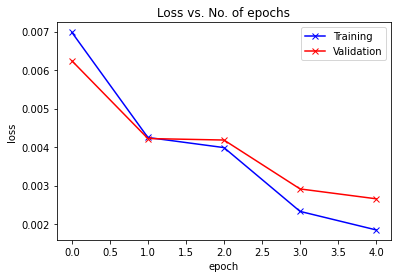

In [106]:
plot_losses(history)


In [107]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

In [108]:
for x in range(10):
    img, label = test_Dataset[x]
    print('Label:', label, ', Predicted:', predict_image(img, model))
    

Label: tensor(6) , Predicted: 6
Label: tensor(5) , Predicted: 5
Label: tensor(10) , Predicted: 10
Label: tensor(0) , Predicted: 0
Label: tensor(3) , Predicted: 3
Label: tensor(21) , Predicted: 21
Label: tensor(10) , Predicted: 17
Label: tensor(14) , Predicted: 14
Label: tensor(3) , Predicted: 3
Label: tensor(7) , Predicted: 7


In [110]:
# Save Pytorch Model
FILE = "/home/ayon_chakroborty/Desktop/Cardano DNN/model3.pth"
torch.save(model.state_dict(), FILE)

onnx_model_path = "/home/ayon_chakroborty/Desktop/Cardano DNN/CNNmodel_version_3.onnx"
x = torch.randn(1, 1, 28, 28, device='cuda') # Sample input in the shape that the model expects
torch.onnx.export(model, x, onnx_model_path, verbose=True)


graph(%input.1 : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %network.0.weight : Float(28, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.0.bias : Float(28, strides=[1], requires_grad=1, device=cuda:0),
      %network.2.weight : Float(28, 28, 3, 3, strides=[252, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.2.bias : Float(28, strides=[1], requires_grad=1, device=cuda:0),
      %network.5.weight : Float(56, 28, 3, 3, strides=[252, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.5.bias : Float(56, strides=[1], requires_grad=1, device=cuda:0),
      %network.7.weight : Float(56, 56, 3, 3, strides=[504, 9, 3, 1], requires_grad=1, device=cuda:0),
      %network.7.bias : Float(56, strides=[1], requires_grad=1, device=cuda:0),
      %network.11.weight : Float(512, 2744, strides=[2744, 1], requires_grad=1, device=cuda:0),
      %network.11.bias : Float(512, strides=[1], requires_grad=1, device=cuda: